In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from ROOT import TFile, TH1D


from helpers import *
from gaussfit import *

# Create timeserie for just one pmt

def _getReadout(rr): 
    
    readout=0.01
    
    if rr in [ 5837, 5984, 6001, 6030, 6036, 6069, 6101, 6372, 6232, 6736, 6633, 6628, 6608, 6603, 6555 ]:
        readout=0.03
    elif rr in [ 5260, 5390, 5457, 5573, 5635 ]:
        readout=0.025
    elif rr in [ 5679 ]:
        readout=0.03
    
    return readout # units in this case is kHz 

def pol(x,a, b):
    return a + x*b

def getDfFromRoot(filename, directory="bkgcalibration"):
      
    tfile = TFile.Open(filename, "READ")
    
    if not tfile.cd(directory):
        print("Unknown %s directory in file %s!" % ( directory, filename ))
        return 
    
    tdirectory = tfile.Get(directory)

    #Get the histograms and the pmt number
    histograms = [ tdirectory.Get(key.GetName()) for key in tdirectory.GetListOfKeys()  if "hamplitude" in key.GetName() ]
    pmt = np.array([ int(key.GetName().split("hamplitude")[-1]) for key in tdirectory.GetListOfKeys()  if "hamplitude" in key.GetName() ])

    # Bin 6 should correspond to 2.1 mV

    all_counts = np.array( [hist.Integral(0, -1) for hist in histograms ])
    thr_counts = np.array([ hist.Integral(4, -1) for hist in histograms ])
    
    #keep only valid entries
    sel_good = np.where( all_counts>0 )
    
    runval = [ entry.run for entry in tdirectory.Get("event")][0]
    run = np.full( len(pmt[sel_good]), runval )
    events = np.full( len(pmt[sel_good]), tdirectory.Get("event").GetEntries()  )
    
    readouts = [ _getReadout(rr) for rr in run ]
    
    ratio = thr_counts[sel_good] / ( events * readouts )
    eratio = np.sqrt(thr_counts[sel_good]) / ( events * readouts )
     
    df = pd.DataFrame({'pmt' : pmt[sel_good], "run" : run, "events" : events, "counts":all_counts[sel_good], "counts_thr":thr_counts[sel_good], "ratio": ratio, "eratio":eratio} )
    
    timestamp = [ entry.timestamp for entry in tdirectory.Get("event")][0]
    
    df["timestamp"] = timestamp
    df.set_index("timestamp", inplace=True)
     
    return df


Welcome to JupyROOT 6.22/08


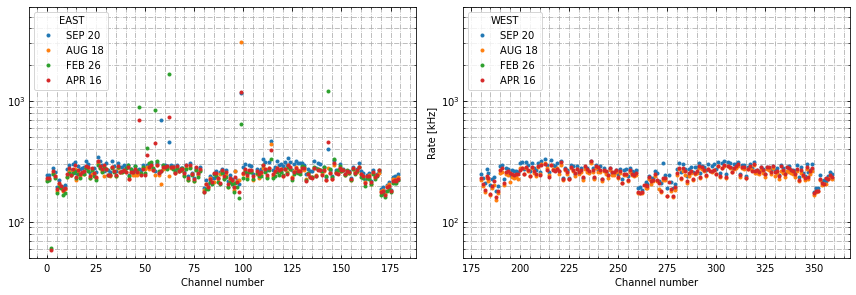

In [2]:
fig,ax = plt.subplots(1,2, figsize=(12, 4.2))

# Rates only for a specific run
sdf  = getDfFromRoot("../histograms/pulseDistributionHist_run6736.root") # SEP 20
sdf1 = getDfFromRoot("../histograms/pulseDistributionHist_run6633.root") # SEP 07
sdf2 = getDfFromRoot("../histograms/pulseDistributionHist_run6628.root") # SEP 05
sdf3 = getDfFromRoot("../histograms/pulseDistributionHist_run6608.root") # SEP 01
sdf4 = getDfFromRoot("../histograms/pulseDistributionHist_run6603.root") # AUG 31 ( readout 50 us)
sdf5 = getDfFromRoot("../histograms/pulseDistributionHist_run6555.root") # AUG 18
sdf6 = getDfFromRoot("../histograms/pulseDistributionHist_run5077.root") # FEB 26 ( readout 10 us)
sdf7 = getDfFromRoot("../histograms/pulseDistributionHist_run5573.root") # APR 16


ax[0].plot( sdf[sdf.pmt<180]['pmt'], sdf[sdf.pmt<180]['ratio'], '.', label='SEP 20' )
ax[0].plot( sdf5[sdf5.pmt<180]['pmt'], sdf5[sdf5.pmt<180]['ratio'], '.', label='AUG 18' )
ax[0].plot( sdf6[sdf6.pmt<180]['pmt'], sdf6[sdf6.pmt<180]['ratio'], '.', label='FEB 26' )
ax[0].plot( sdf7[sdf7.pmt<180]['pmt'], sdf7[sdf7.pmt<180]['ratio'], '.', label='APR 16' )
ax[0].legend(title="EAST", loc='upper left')
ax[0].set_yscale("Log")
ax[0].set_ylim( (50, 6000) )
ax[0].set_xlabel("Channel number")
ax[1].set_ylabel("Rate [kHz]")

ax[1].plot( sdf[sdf.pmt>=180]['pmt'], sdf[sdf.pmt>=180]['ratio'], '.', label='SEP 20' )
ax[1].plot( sdf5[sdf5.pmt>=180]['pmt'], sdf5[sdf5.pmt>=180]['ratio'], '.', label='AUG 18' )
ax[1].plot( sdf6[sdf6.pmt>=180]['pmt'], sdf6[sdf6.pmt>=180]['ratio'], '.', label='FEB 26' )
ax[1].plot( sdf7[sdf7.pmt>=180]['pmt'], sdf7[sdf7.pmt>=180]['ratio'], '.', label='APR 16' )
ax[1].legend(title="WEST", loc='upper left')
ax[1].set_yscale("Log")
ax[1].set_ylim( (50, 6000) )
ax[1].set_xlabel("Channel number")
ax[1].set_ylabel("Rate [kHz]")

plt.tight_layout()


#print( sdf1[ sdf1.ratio > 1000 ] )


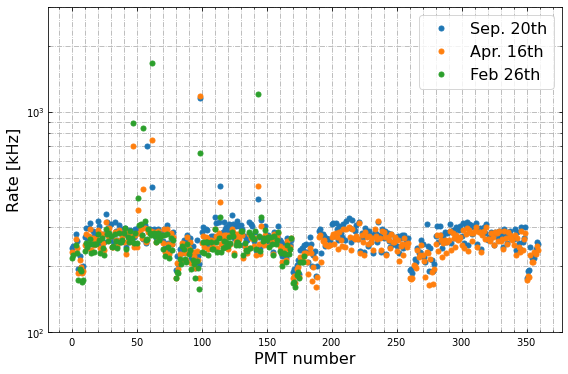

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8, 5.3))

ax.plot( sdf['pmt'] , sdf['ratio'],   'o', markersize=5,   label='Sep. 20th' )
ax.plot( sdf7['pmt'], sdf7['ratio'], 'o', markersize=5, label='Apr. 16th' )
ax.plot( sdf6['pmt'], sdf6['ratio'], 'o', markersize=5, label='Feb 26th' )

ax.legend(loc='upper right', fontsize=16)
ax.set_yscale("Log")
ax.set_ylim( (100, 3000) )
ax.set_xlabel("PMT number", fontsize=16)
ax.set_ylabel("Rate [kHz]", fontsize=16)

plt.tight_layout()

plt.savefig("compare_rates.pdf")
plt.show()